# Decision Trees using Scikit-Learn
## AUTHOR: Alma Qasreena binti Morsidi

This Jupyter Notebook provide the example of simple Machine Learning classification using Scikit-Learn.

We will be using the following modelling techniques:

Deep Neural Network (DNN)
Adaptive Boosting (AdaBoost)
Gradient Boosting
Histogram-Based Gradient Boosting
AdaBoost, Gradient Boosting and Histogram-Based Gradient Boostingis one of the most popular boosting algorithm method for Decision Tree that is shown in this notebook

We begin by importing a few essential libraries and then load the data sets that will be use

In [1]:
%matplotlib inline

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Use flag to make it easier to compare the line produced by DNN, AdaBoost, Gradient Boosting, Histogram Gradient Boosting
# In order to compare just one type of boosting to Likelihood Discriminator simply change the others to False

PLOT    = True
DO_DNN  = True
DO_AB   = True
DO_GB   = True
DO_HG   = True
VERBOSE = False

The data set is available in two formats: ROOT and HDF5. The former is predominantly used by the high energy physics community, while the latter is more familiar to data scientists and other users.

In this notebook, we will be using ROOT files.The uproot package can be used to read a .root file to Python without having to necessarily install the whole ROOT software.

In [6]:
# load the ROOT files

filePath   =  'opendata-cms-ml-master/files/JetNtuple_RunIISummer16_13TeV_MC_1_skimmed.root'
tree       =   uproot.open(filePath)['jetTree']


In [7]:
# Create and fill a dataframe
df             = pd.DataFrame()
remaining_vars = []

# Classification of Quark or Gluon Jets

The main objective in this example is to train a simple machine learning so that it will be able to classify which jets originate from gluons or quark(up,down and strange). This is an important task, since on the observable macroscopic level the two types of jets look very similar, but from a physical point of view the difference between them is significant.

As a result of the transfer of momentum for interacting partons in high energy proton-proton collision, accelerating parton will radiate gluon and quark. This chain reaction produces a shower of jets for quarks and gluons. These observed jets are the one which we are to classify as quark or gluon jets.

Traditionally in the CMS collaboration, the task of identifying quark and gluon jets has been done by building a likelihood-based discriminator from three theoretically-motivated variables (see the public physics analysis summary CMS-PAS-JME-13-002 for more detailed information).

In [8]:
# First remove all the other types of jets from the data except the gluon and the light quark (UDS) jets
for key in tree.keys():

    if str(type(tree[key].array()[0])) != "":
        df[key] = np.array(tree[key].array())
    else:
        remaining_vars.append(key)
    pass

df = df[(df.isPhysG==1) | (df.isPhysUDS==1)].reset_index()


if VERBOSE: print(df)
    
if VERBOSE:      
    print("Remaining variables not accounted for:")
    print(remaining_vars)


To differentiate quark and gluon jets, we will be using three variable. From left to right these variables are the jet multiplicity (QG_mult), the jet momentum distribution variable (QG_ptD) and the jet minor axis (QG_axis2).

Jet multiplicity is the number of particles contained in the jet. Gluons are expected to radiate more intensely, so on average gluon jets contain more particles.

The jet momentum distribution variable is defined as $ p_{T} D = \frac{\sqrt{\sum_i p_{T,i}^2}}{\sum_i p_{T,i}} $ where $p_{T,i}$ is the transverse momentum of a particle and the sum $ i $ is over the jet's constituents. It describes how the total transverse momentum of a jet is distributed to its constituents. Quark jets are expected to have fewer constituents carrying the majority of the jet's momentum, which means that the value of the transverse momentum of a particle is on average larger for quark jets.

The jet minor axis (often also denoted by $ \sigma_{2} $) describes the width of the jet when it is approximated as an ellipse. Gluon jets are on average wider than quark

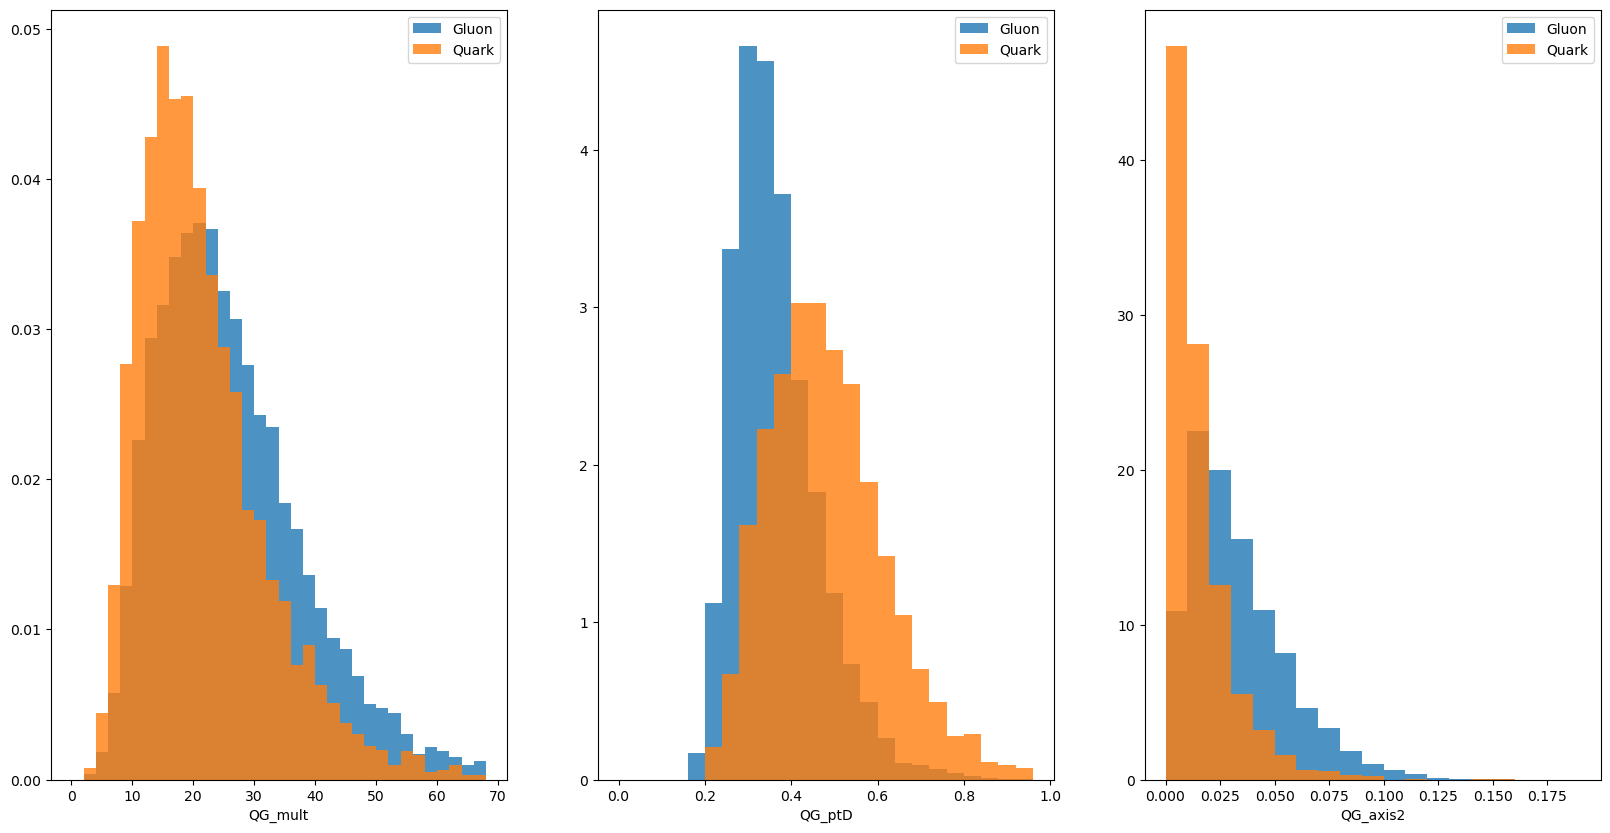

In [9]:
if PLOT:
    #
    #Plotting Variables
    #

    hist_columns = ['QG_mult','QG_ptD','QG_axis2']
    binnings = [np.arange(0,70,2), np.arange(0.0,1.0,0.04), np.arange(0.0,0.2,0.01)]
    ind = 0
    fig, axes = plt.subplots(1, 3, figsize=(20,10))

    for column in hist_columns:
        axes[ind].hist( df[df.isPhysG==1][column], bins=binnings[ind], alpha=0.8, label='Gluon', density=1 )
        axes[ind].hist( df[df.isPhysUDS==1][column], bins=binnings[ind], alpha=0.8, label='Quark', density=1 )
        axes[ind].set_xlabel(column)
        axes[ind].legend()
        ind = ind+1 

<Figure size 640x480 with 0 Axes>

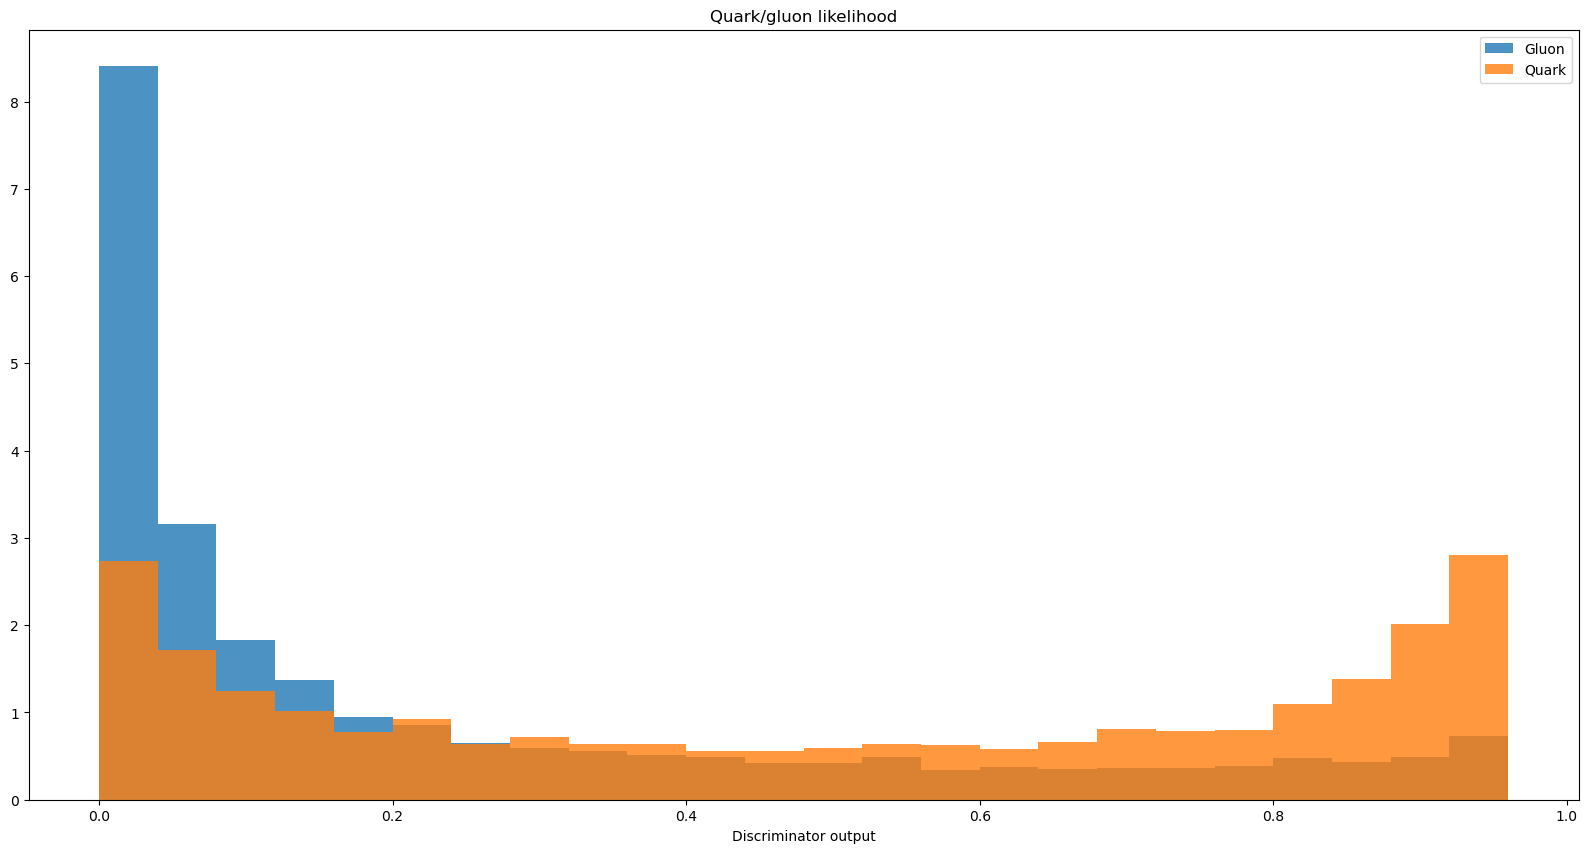

In [10]:
if PLOT:
    plt.clf()
    binning = np.arange(0.0, 1.0, 0.04)
    plt.figure( figsize=(20,10))
    plt.hist( df[df.isPhysG==1]['jetQGl'], bins=binning, alpha=0.8, label='Gluon', density=1 )
    plt.hist( df[df.isPhysUDS==1]['jetQGl'], bins=binning, alpha=0.8, label='Quark', density=1 )
    plt.legend()
    plt.xlabel('Discriminator output')
    plt.title('Quark/gluon likelihood');

# Dividing the data

Before we start the process of classifying the data using DNN, AdaBoost, Gradient Boosting classifier and Histogram Gradient Boosting we need to first divide the data randomly into train and test sets. Our target output is the <b>isPhysUDS</b> column, the value of which is one for light quark jets and zero for gluon jets. Hence the output will be similar to the likelihood discriminator, allowing us to directly compare their performance

The last line of code in the cell below is the input features which is use in all 4 types of classifier. In addition to the previous variables, jetPT and jetETA is also added to improve the peformance of classification.

jetPT is the transverse momentum of the jets.

jetETA is the pseudorapidity of the jet. Pseudorapidity is related to the polar angle of the jet's direction in the cylindrical coordinate system of the CMS detector.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

train, test = train_test_split(df, test_size=0.2, random_state=42)

test_y = test.isPhysUDS

input_features = ['jetPt', 'jetEta', 'QG_mult', 'QG_ptD', 'QG_axis2']

train_y = train.isPhysUDS
test_y = test.isPhysUDS 

train_x = train[input_features]
test_x = test[input_features]

# normalize the features
train_x_mean = train_x.mean()
train_x_std = train_x.std()

train_x = (train_x - train_x_mean) / train_x_std
test_x = (test_x - train_x_mean) / train_x_std


# Deep Neural Network (DNN)

In [13]:
if DO_DNN:
    
    #
    # Deep Neural Network (DNN)
    #
    import tensorflow as tf
    import keras.backend as K

    sess = tf.compat.v1.Session()
    tf.compat.v1.keras.backend.set_session(sess)

    from keras.models import Model, Sequential
    from keras.layers import Input, Dense, Dropout
    from sklearn.utils import class_weight

    # Define the DNN architecture
    model = Sequential()
    model.add(Dense(100, kernel_initializer='normal', activation='relu', input_dim=train_x.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])

    # Weight the training samples so that there is equal weight on gluon and quark jets
    # even if there are different amount of them in the training set
    class_weights = class_weight.compute_class_weight(
                                                        class_weight  = 'balanced',
                                                        classes  = np.unique(train_y),
                                                        y =   train_y
                                                    )

    class_weights = dict(zip(np.unique(train_y), class_weights))

    # Train the model
    model.fit(train_x,
              train_y,
              epochs=20,
              batch_size=128,
              class_weight=class_weights,
              validation_split=0.2,
              shuffle=True,
              verbose=1);
    
    # Prediction on the test set
    pred_y_dnn = model.predict(test_x)



Epoch 1/20
70/70 [==============================] - 3s 12ms/step - loss: 0.5903 - accuracy: 0.7222 - val_loss: 0.5372 - val_accuracy: 0.7282
Epoch 2/20
70/70 [==============================] - 1s 7ms/step - loss: 0.5279 - accuracy: 0.7439 - val_loss: 0.5029 - val_accuracy: 0.7561
Epoch 3/20
70/70 [==============================] - 1s 7ms/step - loss: 0.5232 - accuracy: 0.7493 - val_loss: 0.5096 - val_accuracy: 0.7543
Epoch 4/20
70/70 [==============================] - 1s 7ms/step - loss: 0.5222 - accuracy: 0.7510 - val_loss: 0.5268 - val_accuracy: 0.7439
Epoch 5/20
70/70 [==============================] - 0s 7ms/step - loss: 0.5211 - accuracy: 0.7506 - val_loss: 0.5113 - val_accuracy: 0.7516
Epoch 6/20
70/70 [==============================] - 1s 7ms/step - loss: 0.5210 - accuracy: 0.7495 - val_loss: 0.5110 - val_accuracy: 0.7561
Epoch 7/20
70/70 [==============================] - 0s 7ms/step - loss: 0.5208 - accuracy: 0.7504 - val_loss: 0.5006 - val_accuracy: 0.7574
Epoch 8/20
70/70 [

<Figure size 640x480 with 0 Axes>

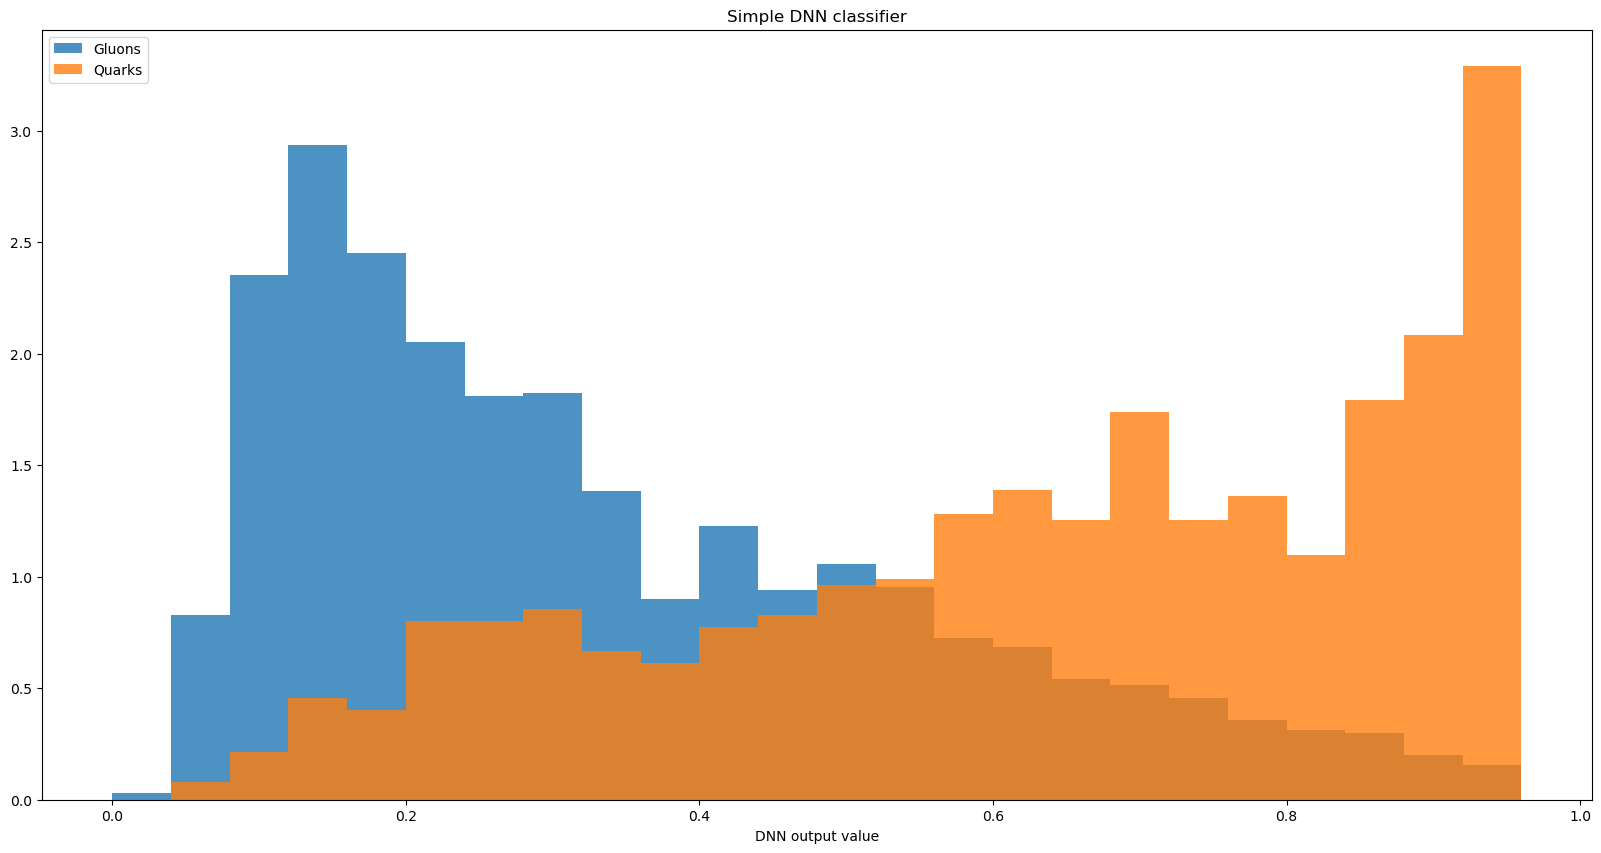

In [14]:
if PLOT and DO_DNN:

    plt.clf()
    binning = np.arange(0.0, 1.0, 0.04)
    plt.figure( figsize=(20,10))
    plt.hist( pred_y_dnn[test_y==0], bins=binning, alpha=0.8, label="Gluons", density=1 )
    plt.hist( pred_y_dnn[test_y==1], bins=binning, alpha=0.8, label="Quarks", density=1 )
    plt.legend()
    plt.xlabel('DNN output value')
    plt.title('Simple DNN classifier');
    
    # Plot for ROC Curve
if DO_DNN:
    fpr_dnn, tpr_dnn, thresholds_dnn  = roc_curve(test_y, pred_y_dnn)
    roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

However, in order to fairly compare the performance of the classifier being used and the traditional likelihood discriminator, we should look at the corresponding Receiver Operating Curve (ROC) curve produced. Therefore in the following classifier we will not plot the classifier output graph. Instead we will directly plot the ROC curve all in the same graph.

# AdaBoost

The module sklearn.ensemble includes the popular boosting algorithm AdaBoost. The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction.

This example is made with reference from [Scikit-Learn](https://scikit-learn.org/stable/modules/ensemble.html#adaboost) documentation on AdaBoost.

In AdaBoost the method used is decision_function to compute the decision function for [test_x](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier). Further explanation on the method available for AdaBoost classifier is available here

In [15]:
if DO_AB:

    from sklearn.ensemble import AdaBoostClassifier 

    clf = AdaBoostClassifier(n_estimators=100, random_state=0)
    clf.fit(train_x, train_y)

    # Prediction on the test set
    pred_y_ab = clf.decision_function(test_x)
    
    # Plot for ROC Curve
    fpr_ab, tpr_ab, thresholds_ab  = roc_curve(test_y, pred_y_ab)
    roc_auc_ab = auc(fpr_ab, tpr_ab)


# Gradient Boosting

Gradient Tree Boosting or Gradient Boosted Decision Trees (GBDT) is a generalization of boosting to arbitrary differentiable loss functions. GBDT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems in a variety of areas including Web search ranking and ecology.

This example is made with reference from [Scikit-Learn](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) documentation on Gradient Boosting.

The method used to predict the test set in Gradient Boosting is the same as AdaBoost which is decision_function. Further explanation on the method available for Gradient Tree Boosting is available [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)

In [16]:
if DO_GB:

    from sklearn.ensemble import GradientBoostingClassifier

    clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
    clf.fit(train_x, train_y)

    # Prediction on the test set
    pred_y_gb = clf.decision_function(test_x)
    
    
    # Plot for ROC Curve
    fpr_gb, tpr_gb, thresholds_gb  = roc_curve(test_y, pred_y_gb)
    roc_auc_gb = auc(fpr_gb, tpr_gb)


# Histogram-Based Gradient Boosting

Scikit-learn 0.21 introduced two new implementations of gradient boosting trees, namely HistGradientBoostingClassifier and HistGradientBoostingRegressor but since we are doing classification.Hence we are using HistGradientBoostingClassifier.These histogram-based estimators can be orders of magnitude faster than GradientBoostingClassifier when the number of samples is larger than tens of thousands of samples.

This example is made with reference from [Scikit-Learn](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting) documentation on Histogram Gradient Boosting.

The method used to predict the test set in Histogram Gradient Boosting is the same as before which is decision_function. Further explanation on the method available for Histogram Gradient Tree Boosting is available [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier)

In [17]:
if DO_HG:

    
    from sklearn.ensemble import HistGradientBoostingClassifier
    clf = HistGradientBoostingClassifier()
    clf.fit(train_x, train_y)

    # Prediction on the test set
    pred_y_hg = clf.decision_function(test_x)

    # Plot for ROC Curve
    fpr_hg, tpr_hg, thresholds_hg  = roc_curve(test_y, pred_y_hg)
    roc_auc_hg = auc(fpr_hg, tpr_hg)
    

# Plotting ROC Curve

The following codes will lastly produced an ROC curve graph to fairly compare the performance of the traditional likelihood discriminator as well as the classifiers that we used. The larger the area under the curve (AUC), the better the performance of the classifier.

<Figure size 640x480 with 0 Axes>

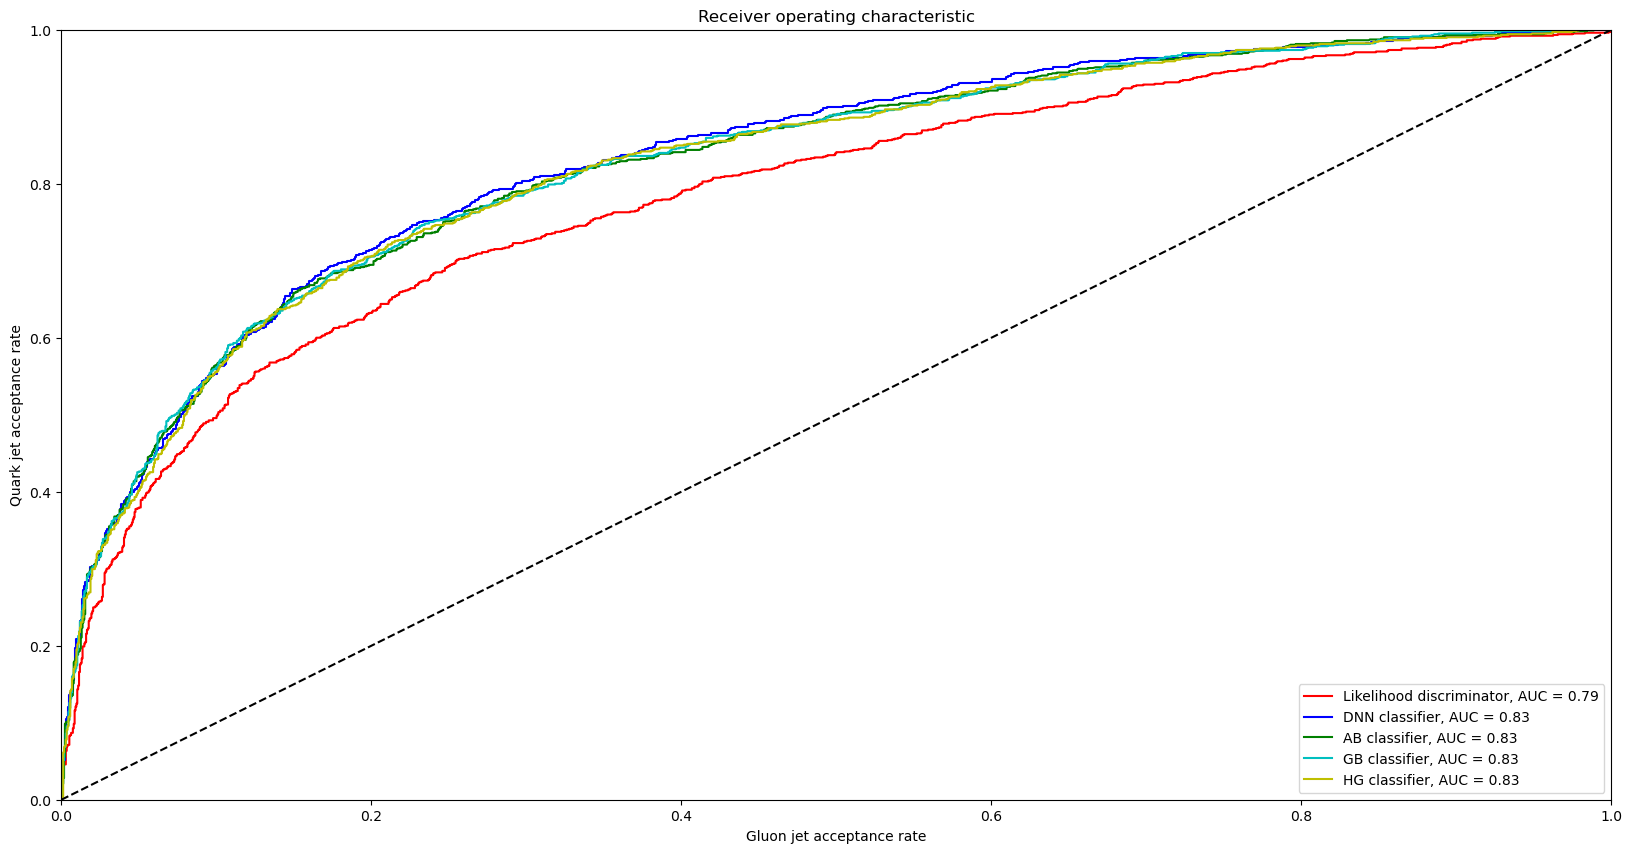

In [18]:
#Plot for ROC (likelihood Discriminator)
fpr_qgl, tpr_qgl, thresholds_qgl = roc_curve(test_y, test.jetQGl)
roc_auc_qgl = auc(fpr_qgl, tpr_qgl)

if PLOT:

    plt.clf()
    plt.figure( figsize=(20,10))
    plt.plot(fpr_qgl, tpr_qgl, 'r', label='Likelihood discriminator, AUC = %0.2f'% roc_auc_qgl)

    if DO_DNN: 
        plt.plot(fpr_dnn, tpr_dnn, 'b', label='DNN classifier, AUC = %0.2f'% roc_auc_dnn)
    if DO_AB : 
        plt.plot(fpr_ab , tpr_ab , 'g', label='AB classifier, AUC = %0.2f'% roc_auc_ab)
    if DO_GB : 
        plt.plot(fpr_gb , tpr_gb , 'c', label='GB classifier, AUC = %0.2f'% roc_auc_gb)
    if DO_HG : 
        plt.plot(fpr_hg , tpr_hg , 'y', label='HG classifier, AUC = %0.2f'% roc_auc_hg)
        
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc = 'lower right')
    plt.title("Receiver operating characteristic")
    plt.ylabel('Quark jet acceptance rate')
    plt.xlabel('Gluon jet acceptance rate');